<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/PFLD/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Add your name and filepath to the project folder so that you can load the datasets.


In [3]:
USER = "John"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]
DATASETS_PATH = os.path.join(PROJECT_FILEPATH, "datasets", "300W-3D")

## Data Preparation

In [4]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [38]:
def get_dataset_filenames(path):
  return [os.path.join(path, name.split('.')[0]) for name in os.listdir(path) if name.endswith(".mat")]

# Using only IBUG and AFW is fine because of their size. If you add HELEN
# with the current setup, it will take like 10 min to load and 3 min per epoch
datasets = [
            "IBUG", 
            "AFW", 
            "HELEN", 
            # "LFPW"
            ]
filepaths = [get_dataset_filenames(f"{PROJECT_FILEPATH}/datasets/300W-3D/{ds}") for ds in datasets]
filepaths = [item for sublist in filepaths for item in sublist] # Flattens the list

def generate_pose():
  for path in filepaths:
    mat = loadmat(path + ".mat")
    yield mat["Pose_Para"][0][0:3]

def generate_image():
  for path in filepaths:
    img = plt.imread(path + ".jpg")
    yield img.astype("float32") / 255.0

def generate_landmarks():
  for path in filepaths:
    mat = loadmat(path + ".mat")
    yield mat["pt2d"].transpose().reshape((-1, 136)).squeeze()


def generate():
  for i in range(0, len(filepaths), 16):
    imgs = []
    poses = []
    landmarks = []
    for path in filepaths[i:i+16]:
      mat = loadmat(path + ".mat")
      img = plt.imread(path + ".jpg")
      img = img.astype("float32") / 255.0
      imgs.append(img)
      pose =  mat["Pose_Para"][0][0:3]
      poses.append(pose)
      points = mat["pt2d"].transpose().reshape((-1, 136)).squeeze() / 450
      landmarks.append(points)
    yield ( np.array(imgs), {"pose" : np.array(poses), "landmarks" : np.array(landmarks)})


ds = tf.data.Dataset.from_generator(
    generate,
    output_types=(tf.float64,{"pose": tf.float64, "landmarks": tf.float64})
)

TF_DATASETS = os.path.join(PROJECT_FILEPATH, "datasets", "tf-datasets")

ds.cache()
for record in ds.take(2):
  print(record[0].numpy().shape)


# for i in range(0, 5):
#   record_batch_size = 500
#   print("Test", i*record_batch_size, min((i+1)*record_batch_size, filepaths.shape[0]), filepaths.shape[0])
#   fp = filepaths[i*record_batch_size:min((i+1)*record_batch_size: filepaths.shape[0])]
#   images, labels = get_examples(fp)
#   print(images.shape, labels.shape)
#   total_dataset_count = fp.shape[0]
#   train_count = math.floor(total_dataset_count*0.65)
#   val_count = math.floor(total_dataset_count*0.1)
#   test_count = total_dataset_count - (train_count + val_count)
#   convert_batch(f"cropped-train-{i}.tfrecord.gz", images, labels, 0, train_count)
#   convert_batch(f"cropped-val-{i}.tfrecord.gz", images, labels, train_count+1, train_count+1+val_count)
#   convert_batch(f"cropped-test-{i}.tfrecord.gz", images, labels, train_count+val_count+1, total_dataset_count)


(16, 450, 450, 3)
(16, 450, 450, 3)


## [PFLD Model](https://arxiv.org/pdf/1902.10859.pdf)


In [66]:
c = tf.constant([1,2,3], dtype=tf.float64)
tf.math.cos(c)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 0.54030231, -0.41614684, -0.9899925 ])>

In [59]:

def relu6(x):
  return tf.clip_by_value(x, 0, 6)

def mobilenet_block(x:layers.Layer, t=2, c=64, s=2, name=None):
  """
  MoblieNetv2 residual block
  Arguments
  -----------
    x: keras layer input
    t: expansion factor based on size of input layer
    c: number of channels
    s: stride width/height
  """
  in_channels = x.shape[-1]
  l = layers.Conv2D(in_channels * t, (1,1), strides=(1,1), padding="same", name=name)(x) 
  l = layers.Activation(relu6)(l)
  l = layers.DepthwiseConv2D((s,s), padding="same")(l)
  l = layers.Activation(relu6)(l)
  l = layers.Conv2D(c, (1,1), strides=(1,1), padding="same")(l)
  return layers.Add()([l,x])

def create_PFLD_model(input_shape, training=True):
  """
  Builds a backbone model that takes in an image and outputs 68 landmark locations.
  If training is true, it attaches the aux model
  """
  input_layer = layers.Input(input_shape, name="model_input")
  x = layers.Conv2D(64,(3,3), strides=(2,2), activation="relu")(input_layer)
  x = layers.DepthwiseConv2D(64, strides=(1,1), activation="relu")(x)
  for _ in range(5):
    x = mobilenet_block(x, t=2, c=64, s=2)
  aux_in = mobilenet_block(x, t=2, c=64, s=2) # TODO: c = 128 but theres an error so 64 for now
  aux_out = create_aux_model(aux_in)
  x = aux_in
  for _ in range(6):
    x = mobilenet_block(x, t=4, c=64, s=2)
  x = mobilenet_block(x, t=2, c=64, s=1) # c = 16 but ^



  x = layers.Conv2D(32,(3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(32,(7,7), strides=(1,1), activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(136, activation="relu", name="landmarks")(x)
  # TODO : Finish loss
  loss = K.mean((1 - tf.math.cos(aux_out)))
  PFLD =  Model(name="PFLM_Backbone", inputs=input_layer, outputs=[x, aux_out])
  PFLD.add_loss(loss)
  return PFLD
  
  


def create_aux_model(input_layer: layers.Layer):
  """
  Auxiliary model takes in the latent image representation from the MobileNet
  layers and produces an estimate of the pitch, yaw and roll of the face
  """

  x = input_layer
  x = layers.Conv2D(128, (3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(128, (3,3), strides=(1,1), activation="relu")(x)
  x = layers.Conv2D(32, (3,3), strides=(2,2), activation="relu")(x)
  x = layers.Conv2D(128, (7,7), strides=(1,1), activation="relu")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(32, activation="relu")(x)
  return layers.Dense(3, activation="relu", name="pose")(x)






In [60]:
from tensorflow.keras.losses import mse
import keras.backend as K

opt = tf.keras.optimizers.Adam()
model = create_PFLD_model((450,450,3))

model.compile(optimizer=opt, loss={"landmarks": "mse", "pose": "mse"}, metrics={"landmarks": tf.keras.metrics.RootMeanSquaredError(), "pose": tf.keras.metrics.RootMeanSquaredError()})

ValueError: ignored

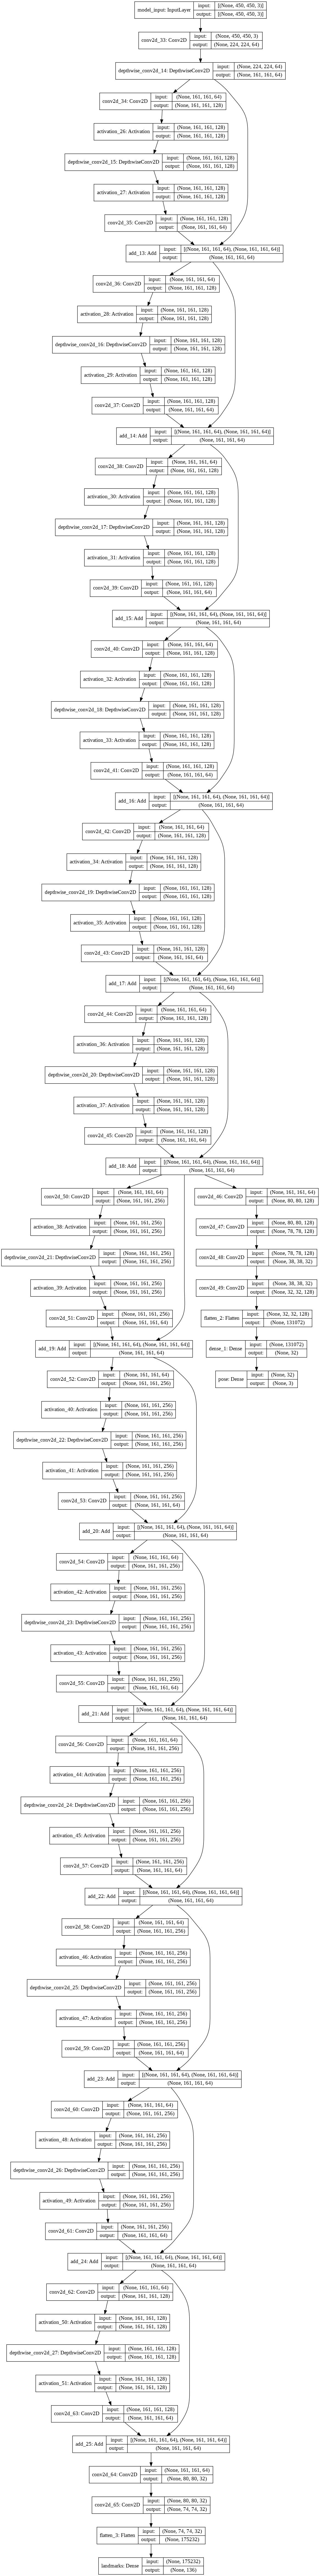

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [39]:
from tensorflow.keras.models import load_model
SHOULD_TRAIN = False
if SHOULD_TRAIN:
  cp_filepath = os.path.join(PROJECT_FILEPATH, "models", "PFLD_Checkpoints")
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cp_filepath, save_best_only=True)
  model.fit(ds, epochs=4, batch_size=5, callbacks = [checkpoint])
else:
  model_path = os.path.join(PROJECT_FILEPATH, "models", "PFLD.h5")
  model = load_model(model_path, custom_objects={"relu6": relu6})

In [47]:
# pd.DataFrame(model.history.history).plot()
images = ds.take(1).map(lambda x,y : x)
landmarks, poses = model.predict(images)
landmarks = landmarks *450

AttributeError: ignored

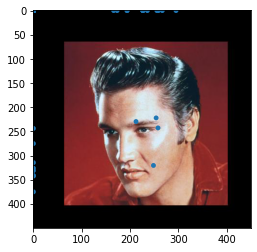

In [55]:
#@title View Predicted Images
image_index = 4 #@param {type:"slider", min:1, max:16, step:1}
points = landmarks * 450
i = 0
for batch in images:
  for img in batch:
    if (i == image_index):
      
      display_landmarks(tf.reshape(img, (450,450,3)), landmarks[image_index])
      break
    i += 1